In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
import basty.project.experiment_processing as experiment_processing
import seaborn as sns

sns.set_theme(style="dark")
from basty.utils import misc
from process_results import BehaviorData
from filter_flies import FilterData
from input import Input

import sys

sys.path.append(r"C:\Users\Grover\Documents\GitHub>basty")

In [2]:
CONFIG_PATH = r"Z:\mfk\basty-projects\main_cfg.yaml"
project = experiment_processing.Project(CONFIG_PATH)
FPS = project.fps
FIG_PATH = r"C:\Users\Grover\Documents\GitHub\deepsleepfigs"

RESULTS_FOLDER = r"Z:\mfk\basty-projects\backup-allnohaltere\results\semisupervised_pair_kNN\predictions.15NN.neighbor_weights-distance.neighbor_weights_norm-log_count.activation-standard.voting-soft.voting_weights-None\exports"

BODY_PART_SETS = {"ProboscisPumping": "prob"}

TMP_RESULT_FOLDER = r"Z:\mfk\basty-projects"

BEHAVIORS = [
    "Idle&Other",
    "PosturalAdjustment&Moving",
    "Feeding",
    "Grooming",
    "ProboscisPumping",
]

In [3]:
io_process = Input(project, RESULTS_FOLDER, TMP_RESULT_FOLDER)
expt_info_df = io_process.load_expt_info()
df_data = io_process.load_predictions()
df_data.drop(["HaltereSwitch", "Noise"], axis=1, inplace=True)
io_process.create_binary_masks_subfolders(BEHAVIORS)

In [6]:
output_path = r'Z:\mfk\basty-projects'
pd.to_pickle(expt_info_df,os.path.join(output_path,'expt_info_df.pkl'))

In [ ]:
llh = misc.get_likelihood(project.data_path_dict, CONFIG_PATH)
llh = llh[llh["ExptNames"].isin(df_data.ExptNames.unique())]

In [5]:
process_data = BehaviorData(df_data, binary_mask_threshold=0.8)

In [ ]:
process_data.process_expt_names_parallel(
    llh, io_process.get_binary_mask_subfolder("ProboscisPumping")
)

In [7]:
masks_based_on_likelihood = io_process.load_binary_mask('ProboscisPumping')
beh_masks = process_data.create_binary_mask_from_behaviors(BEHAVIORS,'ProboscisPumping')
masked_data = process_data.update_dictionary_with_final_masked(masks_based_on_likelihood,beh_masks,'ProboscisPumping')

In [8]:
import process_results
from process_results import BehaviorData
import importlib
importlib.reload(process_results)
from process_results import BehaviorData
bouts_dict = BehaviorData.find_consecutive_bouts_and_snap_fts(masked_data,io_process,'ProboscisPumping',60,30*18,60,force_recalculate=True )

Processing Experiments: 100%|██████████| 61/61 [01:19<00:00,  1.31s/it] 


In [45]:
from filter_timeseries import ProboscisAnalysis
import filter_timeseries
import importlib
importlib.reload(filter_timeseries)
from filter_timeseries import ProboscisAnalysis
prob_dat = ProboscisAnalysis(bouts_dict)

In [11]:
proc_bouts = prob_dat.preprocess_all_data()

In [12]:
import filter_timeseries
import importlib
importlib.reload(filter_timeseries)
from filter_timeseries import ProboscisAnalysis
shortest_length = prob_dat.find_shortest_series('distance.origin-prob')

# Now, you can segment each time series in each dataframe in your data dictionary
for key in bouts_dict.keys():
    bouts_dict[key] = prob_dat.segment_timeseries_column(bouts_dict[key], 'distance.origin-prob', shortest_length)

In [17]:
unpacked_df = prob_dat.unpack_dataframes('distance.origin-prob_segmented')

In [46]:
unpacked_df = ProboscisAnalysis.calculate_spectral_density_for_dataframe(unpacked_df)

In [64]:
import plotly.subplots as sp
import plotly.graph_objects as go

# Assuming your DataFrame is named `df` and contains the 'time_series' and 'PSDs' columns

# Select the row you want to plot (e.g., row with index 0)
row_index = 15
selected_row = unpacked_df.iloc[row_index]

# Extract the time series and PSDs from the selected row
time_series = selected_row['time_series']
psds = selected_row['PSDs']

# Create subplots with shared x-axis
fig = sp.make_subplots(rows=1, cols=2, shared_xaxes=True)

# Add the time series subplot as a line plot
fig.add_trace(go.Scatter(x=list(range(len(time_series))), y=time_series, mode='lines', name='Time Series'), row=1, col=1)

# Add the PSDs subplot as a line plot
fig.add_trace(go.Scatter(x=psds[0], y=psds[1], mode='lines', name='PSDs'), row=1, col=2)

# Update subplot titles and layout
fig.update_layout(
    title='Time Series and Power Spectral Density',
    xaxis=dict(title='Time/Frequency'),
    yaxis1=dict(title='Value', domain=[0.2, 1]),
    yaxis2=dict(title='Power', domain=[0, 0.8]),
    width=800,
    height=400,
    showlegend=True,
    legend=dict(x=0, y=1),
)

# Show the plot
fig.show()


In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of bins for the histogram
n_bins = 50

# Initialize a list to store the histogram for each instance
histograms = []

# For each instance in the dataset
for psd in unpacked_df['PSDs']:
    # Get the frequencies and powers
    frequencies = psd[0]
    powers = psd[1]

    # Filter out frequencies higher than 5 Hz
    powers = [power for freq, power in zip(frequencies, powers) if freq <= 5]

    # Compute the histogram of the powers
    hist, bin_edges = np.histogram(powers, bins=n_bins)

    # Normalize the histogram
    hist = hist / np.sum(hist)

    # Add the histogram to the list
    histograms.append(hist)

# Convert the list of histograms into a 2D array
histograms = np.array(histograms)

# Now, 'histograms' is a 2D array where each row is an instance and each column is a histogram bin.
# You can use this array as input to your machine learning algorithm.


In [73]:
from sklearn.decomposition import PCA

# Create a PCA object
pca = PCA(n_components=3)  # Change this to the number of components you want

# Fit the PCA model to your data and apply the dimensionality reduction
pca_result = pca.fit_transform(histograms)

# Print the explained variance ratio
print('Explained variance ratio:', pca.explained_variance_ratio_)


Explained variance ratio: [0.85441838 0.04498954 0.01971917]


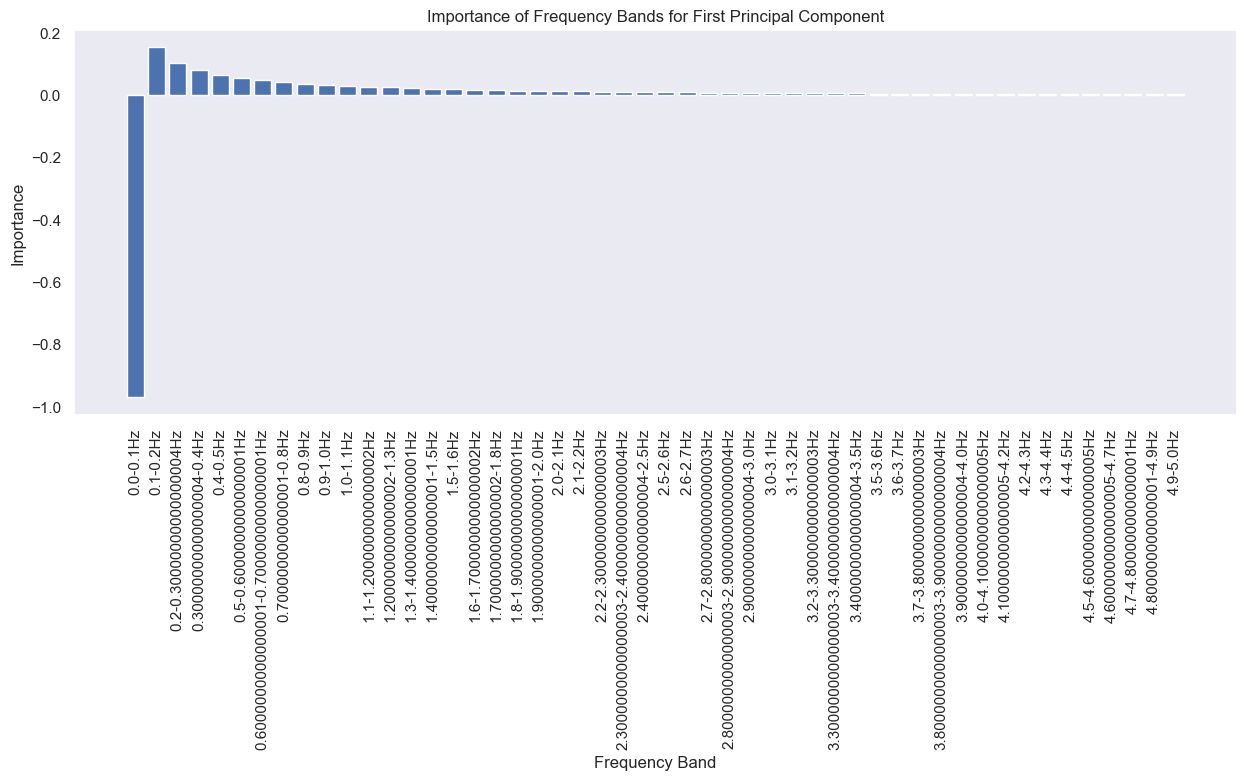

In [74]:
import matplotlib.pyplot as plt

# Get the weights of the original features for the first principal component
component = pca.components_[0]

# Create a list of frequency bands corresponding to your histogram bins
frequency_bands = [f"{0.1*i}-{0.1*(i+1)}Hz" for i in range(50)]

# Create a bar plot
plt.figure(figsize=(15, 5))  # Increase the figure size for better visibility
plt.bar(frequency_bands, component)
plt.xlabel('Frequency Band')
plt.ylabel('Importance')
plt.title('Importance of Frequency Bands for First Principal Component')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better visibility
plt.show()


In [75]:
print('Components:', pca.components_)

Components: [[-9.70155428e-01  1.53016400e-01  1.01830369e-01  7.93587696e-02
   6.50497739e-02  5.50005311e-02  4.64203208e-02  4.01170139e-02
   3.55611998e-02  3.24592069e-02  2.92089617e-02  2.60063320e-02
   2.41257789e-02  2.21508447e-02  1.97363919e-02  1.81298128e-02
   1.65446973e-02  1.54253090e-02  1.39549234e-02  1.30390586e-02
   1.21603914e-02  1.17540769e-02  1.08586897e-02  1.00762422e-02
   9.70833200e-03  9.08984406e-03  8.38115614e-03  7.59720785e-03
   6.73317081e-03  6.35743788e-03  6.07510459e-03  5.82729273e-03
   5.39560862e-03  5.16531021e-03  4.78008758e-03  4.56008188e-03
   4.21022340e-03  3.97222301e-03  3.65139066e-03  3.38595780e-03
   3.19956490e-03  3.01103469e-03  2.73801895e-03  2.55432604e-03
   2.30768820e-03  2.15674082e-03  1.98178324e-03  1.87798878e-03
   1.78122410e-03  1.67153328e-03]
 [ 1.34871646e-01  9.58645410e-01  1.19446823e-01  8.26660111e-04
  -4.69497878e-02 -6.21688104e-02 -6.61057569e-02 -5.99927564e-02
  -6.14564202e-02 -5.93727715

In [157]:
expt_name = 'Fly06292022_5d_A'
#plt.plot(bouts_dict[expt_name]['distance.origin-prob_segmented'][1][200])
len(bouts_dict[expt_name]['distance.origin-prob_segmented'][1])

34

In [209]:
pds2 = spect_density_dict[expt_name]['PSD_50']

In [204]:
psd = (spect_density_dict[expt_name]['PSD_50'][50])

In [205]:

import plotly.express as px

# Plot the spectral density using Plotly
fig = px.line(
    x=psd[0],
    y=psd[1],
    title="PSD for",
    width=700,
    height=400
)
fig.show()

TypeError: 'float' object is not subscriptable

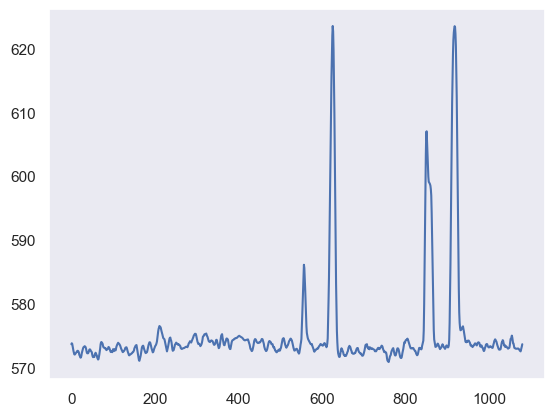

In [160]:
len(bouts_dict[expt_name]['distance.origin-prob_segmented'][2])
expt_name = 'Fly06292022_5d_A'
plt.plot(bouts_dict[expt_name]['distance.origin-prob_segmented'][1][1])

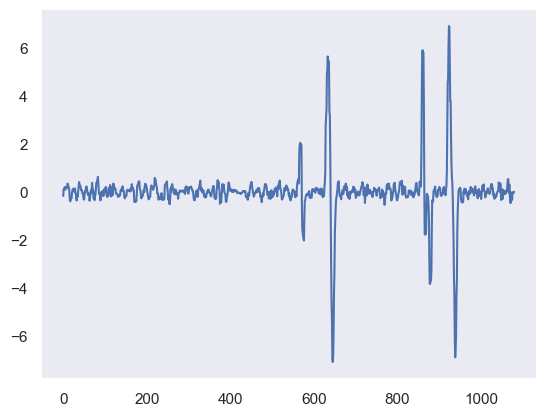

In [127]:
expt_name = 'Fly06292022_5d_A'

dt = np.diff(bouts_dict[expt_name]['distance.origin-prob_segmented'][1][1])
#plt.plot(bouts_dict[expt_name]['distance.origin-prob'][9])
plt.plot(dt)

In [124]:
sig = bouts_dict[expt_name]['distance.origin-prob']
print(type(sig.iloc[0]))

<class 'numpy.ndarray'>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

# let's assume your dictionary is named `experiments`
# get the first key and dataframe from the dictionary
first_key = list(bouts_dict.keys())[0]
first_key ='Fly06292022_5d_A'
first_df = bouts_dict[first_key]

# choose the time series feature you want to transform
feature = 'distance.origin-prob'

# perform STFT on each row
for i, row in first_df.iterrows():
    f, t, Zxx = stft(row[feature], fs=30, nperseg=64, noverlap=32)  # fs=30Hz is the sample rate

    # Plot the spectrogram
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.title(f'Spectrogram for row {i+1} in experiment {first_key}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim([0.2, 1.1])
    plt.pcolormesh(t, f, 10 * np.log10(np.abs(Zxx)), shading='gouraud')
    plt.colorbar(label='dB')

    plt.show()


    # To avoid plotting all rows, break the loop after first one (remove this to plot all rows)



In [ ]:
newDf = pd.merge(df_data, expt_info_df, left_on="ExptNames", right_on="ExptNames")

In [ ]:
# Create a folder named binary mask and a subfolder for each predicted behavior.
# Within that folder save binary mask generated using the likelihood score

In [ ]:
wt_all = newDf[newDf["SD"] == False]
male_wt = wt_all[wt_all["Sex"] == "M"]
female_wt = wt_all[wt_all["Sex"] == "F"]

In [ ]:
newDf

In [ ]:
filterer = FilterData(newDf, llh)

In [ ]:
filterer.plot_mean_likelihood()

In [ ]:
binary_mask = filterer.create_binary_masks(llh, BODY_PART_SETS, 0.7)

In [ ]:
masked_data_df = filterer.apply_binary_masks(binary_mask, newDf)

In [ ]:
masked_data_df

In [ ]:
binary_mask

In [ ]:
masked_data_df

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'masked_data_df'
# and has columns 'ExptNames', 'ValueColumn' (replace with your actual column name)
# Add row numbers if they don't exist
masked_data_df["Row"] = masked_data_df.index

# Pivot the DataFrame
pivoted_df = masked_data_df.pivot(
    index="ExptNames", columns="Row", values="ProboscisPumping"
)

# Create a heatmap using Seaborn, handling NaN values with a different color (e.g., gray)
plt.figure(figsize=(16, 9))
sns.heatmap(
    pivoted_df,
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={"ticks": [0, 1]},
    mask=pivoted_df.isna(),
    linecolor="gray",
)

# Set plot attributes
plt.xlabel("Rows")
plt.ylabel("ExptNames")
plt.title("Heatmap of Data")

# Save the plot as a PNG file
FIG_PATH = r"C:\Users\Grover\Documents\GitHub\deepsleepfigs"
plt.savefig(f"{FIG_PATH}\\heatmap.png", dpi=300, bbox_inches="tight")

# Display the plot in the notebook (optional)
plt.show()

In [ ]:
plot_folder = r"C:\Users\Grover\Documents\GitHub\deepsleepfigs\score_plots"
if not os.path.isdir(plot_folder):
    os.makedirs(plot_folder)

In [ ]:
male_wt["Time"] = male_wt["Idx"].apply(BehaviorData.get_time_stamp)
male_wt.index = pd.to_datetime(list(male_wt["Time"]))
rate = "1S"
male_wt_rs = BehaviorData.resample_df(male_wt, rate, BEHAVIORS)
male_wt_rs["TimeStamp"] = male_wt_rs.index

In [ ]:
male_wt

In [ ]:
llh["Time"] = llh["Idx"].apply(BehaviorData.get_time_stamp)

In [ ]:
BehaviorData.pivot_and_plot(male_wt_rs, "mal_b_scr_", plot_folder, rate, BEHAVIORS)

In [ ]:
import os

In [ ]:
os.listdir(plot_folder)

In [ ]:
df_pivoted = male_wt_rs.pivot(
    index="ExptNames", columns="TimeStamp", values="ProboscisPumping"
)
a4_dims = (25.7, 5.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title("ProboscisPumping")
ax = sns.heatmap(df_pivoted, cmap="YlGnBu")

In [ ]:
male_wt_rs

In [ ]:
unique_expt_names = male_wt["ExptNames"].unique()

a4_dims = (25.7, 5.27)
# Plot the unmasked data heatmap
# plt.figure(figsize=(a4_dims))
# sns.heatmap(unmasked_data, cmap='YlGnBu', yticklabels=unique_expt_names)
# plt.xlabel('Data')
# plt.ylabel('ExptNames')
# plt.title('Unmasked Data')
# plt.savefig(os.path.join(plot_folder,'unmasked_data_heatmap_full_07.png'), dpi=300)  # Save the figure as a PNG file
# plt.show()

In [ ]:
# Plot the masked data heatmap
plt.figure(figsize=(a4_dims))
sns.heatmap(masked_data, cmap="YlGnBu", yticklabels=unique_expt_names)
plt.xlabel("Data")
plt.ylabel("ExptNames")
plt.title("Masked Data")
plt.savefig(os.path.join(plot_folder, "masked_data_heatmap_full_09.png"), dpi=300)
plt.show()

In [ ]:
snap_paths = [
    {expt_names: os.path.join(project.project_path, expt_names, "snap_stft.pkl")}
    for expt_names in project.expt_names
]
snap_col_names = [
    os.path.join(project.project_path, expt_names, "ftname_to_snapft.yaml")
    for expt_names in project.expt_names
]

In [ ]:
df_data

In [ ]:
df_data